In [2]:
import geopandas as gpd
import libpysal
import pandas as pd
import dask_geopandas

In [3]:
import itertools as it
import collections

import pygeos
from numba import njit, prange
import numpy

QUEEN = 1
ROOK = 2

# https://github.com/pysal/libpysal/pull/427


class ContiguityWeightsLists:
    """
    Contiguity for a collection of polygons using high performance
    list, set, and dict containers
    """

    def __init__(self, collection, wttype=1):
        """
        Arguments
        =========

        collection: PySAL PolygonCollection

        wttype: int
             1: Queen
             2: Rook
        """
        self.n = len(collection)
        self.coordinates = pygeos.get_coordinates(collection)
        self.coords_per_geom = pygeos.get_num_coordinates(collection)
        self.coord_indices = numpy.repeat(numpy.arange(self.n), self.coords_per_geom)
        self.edge_indices = numpy.repeat(numpy.arange(self.n), self.coords_per_geom - 1)
        self.wttype = wttype
        self.contiguity()

    def contiguity(self):

        if self.wttype == QUEEN:  # points are hashed
            hashes = _point_hash(self.coordinates)
            indices = self.coord_indices
        elif self.wttype == ROOK:  # edges are hashed
            hashes = _edge_hash(self.coordinates, self.coord_indices, self.coords_per_geom)
            indices = self.edge_indices
        else:
            raise Exception("Weight type {} Not Understood!".format(self.wttype))

        hash_to_geom_lut = collections.defaultdict(set)
        for i, hash_ in enumerate(hashes):
             hash_to_geom_lut[hash_].add(indices[i])

        edgelist = set()
        shared_vertices = []
        for hash_, neighbors in hash_to_geom_lut.items():
             if len(neighbors) > 1:
                for i in neighbors:
                     for j in neighbors:
                        if i != j:
                             edgelist.update([(i, j)])
        self.edgelist = edgelist


@njit
def _point_hash(coordinates):
    n = coordinates.shape[0]
    result = numpy.ones(n)
    for i in range(n):
        target = (coordinates[i, 0], coordinates[i, 1])
        result[i] = hash(target)
    return result


@njit
def _edge_hash(coordinates, indices, n_coordinates_per_geom):
    n_coordinates = coordinates.shape[0]
    n_edges = numpy.sum(n_coordinates_per_geom - 1)
    result = numpy.ones(n_edges)
    offsets = numpy.cumsum(n_coordinates_per_geom)
    on_point = 0
    edge_ix = 0
    for i in range(n_coordinates):
        on_point += 1
        index = indices[i]
        offset = offsets[i]
        tail = coordinates[i]
        if on_point == n_coordinates_per_geom[index]:  # would modulo be faster?
            on_point = 0
            continue
        else:
            head = coordinates[i + 1]

        # ensure left-to-right ordering to avoid reversability issues
        if head[0] > tail[0]:
             head, tail = tail, head
        edge_tuple = (head[0], head[1], tail[0], tail[1])
        result[edge_ix] = hash(edge_tuple)
        edge_ix += 1
    return result

def from_array(geometry_array):
    import pygeos

    all_geoms = pygeos.is_geometry(geometry_array).all()
    assert all_geoms, "Input must be pygeos geometry array."
    _constructor = lambda x: ContiguityWeightsLists(x, wttype=2)
    edgelist = _constructor(geometry_array).edgelist
    return pd.DataFrame(edgelist, columns=["focal", "neighbor"]).assign(weight=1)

In [4]:
signatures = gpd.read_parquet("../../urbangrammar_samba/spatial_signatures/signatures/signatures_combined_levels_orig.pq")

In [8]:
signatures

,kmeans10gb,geometry,level2,signature_type
0,0,"POLYGON Z ((62220.000 798500.000 0.000, 62110....",0.0,0_0
1,0,"POLYGON Z ((63507.682 796515.169 0.000, 63471....",0.0,0_0
2,0,"POLYGON Z ((65953.174 802246.172 0.000, 65950....",0.0,0_0
3,0,"POLYGON Z ((67297.740 803435.800 0.000, 67220....",0.0,0_0
4,0,"POLYGON Z ((75760.000 852670.000 0.000, 75700....",0.0,0_0
...,...,...,...,...
96699,9,"POLYGON ((323321.005 463795.416, 323319.842 46...",8.0,9_8
96700,9,"POLYGON ((325929.840 1008792.061, 325927.377 1...",8.0,9_8
96701,9,"POLYGON ((337804.770 1013422.583, 337800.122 1...",8.0,9_8
96702,9,"POLYGON ((422304.270 1147826.990, 422296.000 1...",8.0,9_8


In [5]:
%%time
w = from_array(signatures.geometry.values.data)

CPU times: user 1min 28s, sys: 3.14 s, total: 1min 31s
Wall time: 1min 31s


In [14]:
w

,focal,neighbor,weight
0,89773,58070,1
1,64658,50056,1
2,82533,16531,1
3,14920,81277,1
4,49401,14797,1
...,...,...,...
251953,459,64234,1
251954,34567,76046,1
251955,76848,35294,1
251956,63402,28287,1


In [10]:
w["focal_type"] = signatures.signature_type.iloc[w.focal.values].values
w["neighbor_type"] = signatures.signature_type.iloc[w.neighbor.values].values

In [11]:
w

,focal,neighbor,weight,focal_type,neighbor_type
0,89773,58070,1,2_1,6_0
1,64658,50056,1,7_0,5_0
2,82533,16531,1,2_0,1_0
3,14920,81277,1,1_0,2_0
4,49401,14797,1,5_0,1_0
...,...,...,...,...,...
251953,459,64234,1,0_0,7_0
251954,34567,76046,1,3_0,8_0
251955,76848,35294,1,8_0,3_0
251956,63402,28287,1,7_0,3_0


In [26]:
matrix = pd.crosstab(w["focal_type"], w["neighbor_type"])

In [14]:
types = {
    "0_0": "Countryside agriculture",
    "1_0": "Accessible suburbia",
    "3_0": "Open sprawl",
    "4_0": "Wild countryside",
    "5_0": "Warehouse/Park land",
    "6_0": "Gridded residential quarters",
    "7_0": "Urban buffer",
    "8_0": "Disconnected suburbia",
    "2_0": "Dense residential neighbourhoods",
    "2_1": "Connected residential neighbourhoods",
    "2_2": "Dense urban neighbourhoods",
    "9_0": "Local urbanity",
    "9_1": "Concentrated urbanity",
    "9_2": "Regional urbanity",
    "9_4": "Metropolitan urbanity",
    "9_5": "Hyper concentrated urbanity",
    "9_3": "outlier",
    "9_6": "outlier",
    "9_7": "outlier",
    "9_8": "outlier",
}

In [27]:
matrix.columns = matrix.columns.map(types)
matrix.index = matrix.index.map(types)

In [28]:
matrix = matrix.drop(columns="outlier").drop("outlier")

In [29]:
matrix

neighbor_type,Countryside agriculture,Accessible suburbia,Dense residential neighbourhoods,Connected residential neighbourhoods,Dense urban neighbourhoods,Open sprawl,Wild countryside,Warehouse/Park land,Gridded residential quarters,Urban buffer,Disconnected suburbia,Local urbanity,Concentrated urbanity,Regional urbanity,Metropolitan urbanity,Hyper concentrated urbanity
focal_type,,,,,,,,,,,,,,,,
Countryside agriculture,0,6,0,3,0,11,7323,181,1,14659,0,3,0,0,3,0
Accessible suburbia,6,0,2710,3573,2,13403,6,2068,1079,4070,3423,0,0,0,0,0
Dense residential neighbourhoods,0,2710,0,4622,3457,3450,0,3632,1246,25,1600,1,0,0,0,0
Connected residential neighbourhoods,3,3573,4622,0,1012,1222,1,2163,1939,35,1508,2,0,1,0,0
Dense urban neighbourhoods,0,2,3457,1012,0,5,0,414,443,1,52,1603,0,0,0,0
Open sprawl,11,13403,3450,1222,5,0,2,10383,660,14793,9521,0,0,0,0,0
Wild countryside,7323,6,0,1,0,2,0,0,2,48,0,4,0,0,1,0
Warehouse/Park land,181,2068,3632,2163,414,10383,0,0,73,4837,3313,30,0,0,0,0
Gridded residential quarters,1,1079,1246,1939,443,660,2,73,0,16,273,133,0,0,0,0


In [33]:
import seaborn as sns
import urbangrammar_graphics as ugg
import matplotlib.pyplot as plt

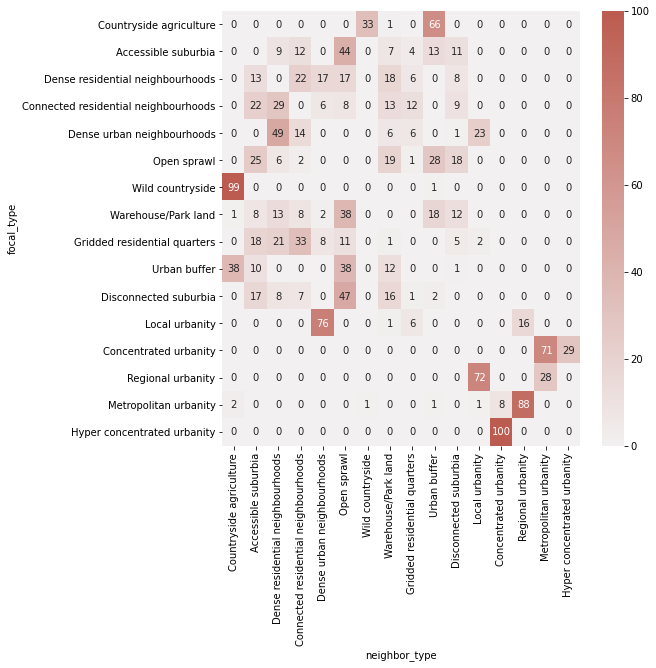

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(matrix.divide(matrix.sum(axis=1), axis=0).astype('float') * 100, cmap=sns.light_palette(ugg.HEX[2], n_colors=256), annot=True, fmt='.0f', vmax=100)
plt.savefig("co_occurence.pdf", bbox_inches="tight")

In [35]:
matrix.to_parquet("co_occurence.pq")